# Import

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from collections import  defaultdict


# Dataset 

In [5]:
root = os.getcwd()
train_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialNoAnomaly', 'artificialNoAnomaly', 'art_daily_small_noise.csv')
valid_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialWithAnomaly', 'artificialWithAnomaly', 'art_daily_jumpsdown.csv')
test_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialWithAnomaly', 'artificialWithAnomaly', 'art_daily_jumpsup.csv')

assert os.path.exists(train_dataset_path), f"Path to train dataset {train_dataset_path} not found"
assert os.path.exists(valid_dataset_path), f"Path to valid dataset {valid_dataset_path} not found"
assert os.path.exists(test_dataset_path), f"Path to test dataset {test_dataset_path} not found"

# Prepare train, valid, and test datasets

In [6]:
train_df = pd.read_csv(train_dataset_path)
valid_df = pd.read_csv(valid_dataset_path)
test_df = pd.read_csv(test_dataset_path)
print('train df = ', train_df.shape)
print('valid df = ', valid_df.shape)
print('test df = ', test_df.shape)
train_df['timestamp'] = train_df.timestamp.astype("datetime64[ns]")
valid_df['timestamp'] = valid_df.timestamp.astype("datetime64[ns]")
test_df['timestamp'] = test_df.timestamp.astype("datetime64[ns]")
train_df.head()

train df =  (4032, 2)
valid df =  (4032, 2)
test df =  (4032, 2)


,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120


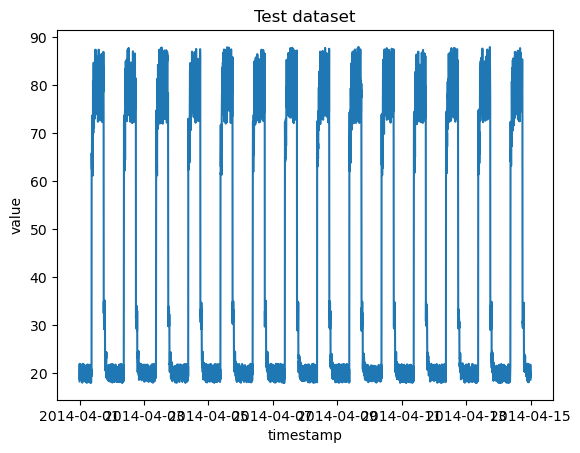

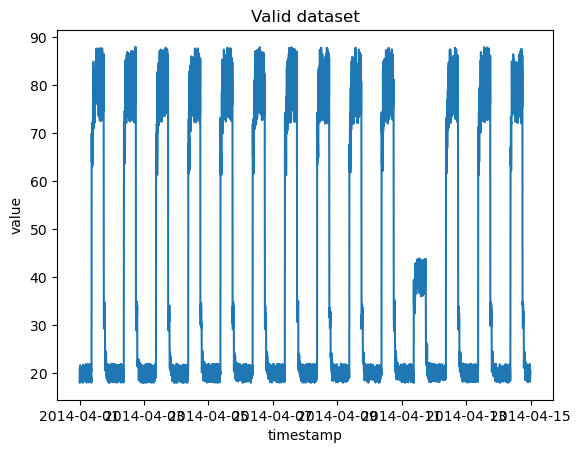

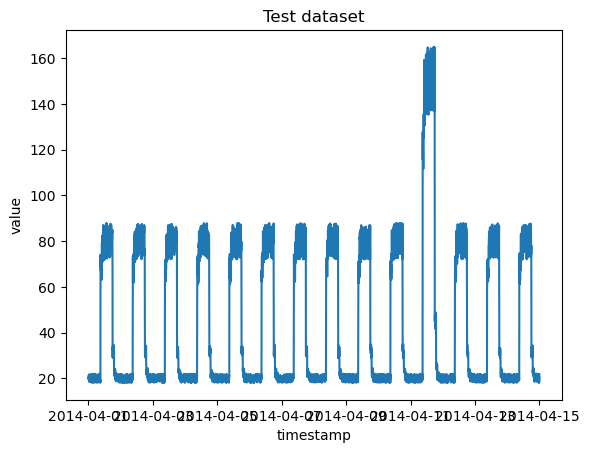

In [7]:
sns.lineplot(y = train_df['value'], x = train_df['timestamp'])
plt.title("Test dataset")
plt.show()
sns.lineplot(y = valid_df['value'], x = valid_df['timestamp'])
plt.title("Valid dataset")
plt.show()
sns.lineplot(y = test_df['value'], x = test_df['timestamp'])
plt.title("Test dataset")
plt.show()

# EDA and Feature Engineering

In [16]:
def normalize(df):
    df = (df - df.min())/(df.std())
    return df

def normalize_std(df):
    df = (df - df.mean())/(df.std())
    return df

def make_sequence(df, col, time_step = 200, normalize_fn = normalize, debug = False):
    #make sure to normalize columns
    df[col] = normalize_fn(df[col])


    array = []
    values = df[col].values
    for i in range(len(values) - time_step + 1):
        array.append(values[i: i + time_step])

    array = np.stack(array)
    if debug:
        print(f'array mean = {np.mean(array)}, max = {np.max(array)}, min = {np.min(array)}, std = {np.std(array)}')
    
    return torch.tensor(array)


X_train = make_sequence(train_df, 'value', normalize_fn= normalize_std, debug = True)
X_valid = make_sequence(valid_df, 'value', normalize_fn= normalize_std, debug = True)
X_test = make_sequence(test_df, 'value',   normalize_fn= normalize_std, debug = True)
print('X train = ', X_train.shape)
print('X valid = ', X_valid.shape)
print('X test = ', X_test.shape)



array mean = 0.00754258780205873, max = 1.6218818486602282, min = -0.8703665949916459, std = 1.0017619085268803
array mean = 0.005793230834212845, max = 1.6897555095894505, min = -0.8544527210521768, std = 1.0009918113531466
array mean = 0.00973666252553481, max = 3.713969885321558, min = -0.8168740233071892, std = 1.0072660092100625
X train =  torch.Size([3833, 200])
X valid =  torch.Size([3833, 200])
X test =  torch.Size([3833, 200])


# Build the model 1

In [17]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size = 256, dropout = 0.5) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(embedding_size),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.LazyLinear(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(input_size),
            nn.ReLU()
        )

        self(torch.zeros(1, input_size))
    
        self.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

In [18]:
def tune(model, X_train, optimizer, criterion, epochs = 1000):

    num_epochs = 20

    loop = tqdm(range(epochs))
    history = defaultdict(list)
    for e in loop:
        model.train()

        X_pred = model(X_train)

        loss = criterion(X_pred, X_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history['train loss'].append(loss.item())

        loop.set_description(f'e = {e}, train loss = {loss.item():.3f}')

    return model, history

def plot(history):
    indices = list(range(len(history['train loss'])))
    sns.lineplot(y = history['train loss'], x =indices, label = 'train')
    plt.title("Train Loss")
    plt.show()

# Set Threshold
### Question
- why do we use MAE over MSE while choosing threshold? 

In [19]:
a = np.random.random(100)
print(a)
print(np.percentile(a, 100))
print(np.max(a))

[0.12694101 0.5447465  0.14288635 0.84854103 0.38613749 0.50539623
 0.24065639 0.29831212 0.43709456 0.43977999 0.6865716  0.07601826
 0.92190517 0.7591621  0.31909938 0.78523442 0.57695882 0.16087335
 0.04246156 0.2450566  0.21628474 0.67465736 0.51956719 0.48361397
 0.76389423 0.36318242 0.66742444 0.79462843 0.20078537 0.09567937
 0.66083122 0.43760459 0.92472768 0.80415715 0.80640536 0.45457111
 0.9321324  0.96633681 0.60212399 0.0494695  0.72159677 0.50853197
 0.81750835 0.04802726 0.3777351  0.14597992 0.22646964 0.69963412
 0.32329678 0.99289392 0.07818127 0.48307737 0.86121852 0.27078647
 0.97943134 0.9205414  0.64706707 0.59462651 0.22195883 0.28344254
 0.09586951 0.3425821  0.39278777 0.75518611 0.81208772 0.10211233
 0.53455722 0.65401054 0.86799902 0.44658551 0.60962865 0.8513052
 0.29550942 0.09973357 0.88109322 0.54485744 0.33023558 0.36680152
 0.55796125 0.87265686 0.08814416 0.56533636 0.05384452 0.86317597
 0.24733665 0.14427887 0.9468549  0.20926059 0.86773584 0.84435

In [20]:
def get_threshold(autoencoder, df, timestep, plot = False, percentile = 100):
    # Use maximum reconstruction error of train data as threshold 
    X_train = make_sequence(df, 'value', time_step=timestep)
    train_reconstruction = autoencoder(X_train.float())

    mae_loss = get_mae(X_train, train_reconstruction)
    mae_loss = mae_loss.squeeze(0).detach().numpy()

    if plot:
        plot_reconstruction_error_dist(mae_loss)

    threshold = np.percentile(mae_loss, percentile)
    return threshold

def plot_reconstruction_error_dist(mae_loss_array):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(mae_loss_array, bins=50, density=True, label="clean", alpha=.6, color="green")
    plt.title('reconstruction  loss histogram')
    plt.show()

def plot_reconstruction(autoencoder, df, timestep):
    X_train = make_sequence(df, 'value', time_step=timestep)
    reconstruction = autoencoder(X_train.float())

    reconstruction = reconstruction[:,1].detach().numpy()
    indices = list(range(len(reconstruction)))
    sns.lineplot(y = df['value'], x = df.index)
    plt.title("Test dataset")
    sns.lineplot(y = reconstruction, x = indices, label = 'reconstruction', color = 'red')
    plt.title('reconstruction')
    plt.show()

def get_mae(input, target):
    return torch.mean(torch.abs(target - input), dim = 1)



# Detect anomaly

In [21]:
def detect_anomaly(autoencoder, valid_df, timestep, threshold):
    # timestep = 300
    X_valid = make_sequence(valid_df, 'value', time_step= timestep)

    valid_reconstruction = autoencoder(X_valid.float())

    mae_loss = get_mae(X_valid, valid_reconstruction)
    print('mae loss = ', mae_loss)

    anomaly_indices = (mae_loss > threshold).detach().numpy()
    valid_reconstruction = valid_reconstruction.detach().numpy()
    X_valid = X_valid.detach().numpy()

    anomaly_df = valid_df[:valid_df.shape[0] - timestep + 1].iloc[anomaly_indices]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
    sns.lineplot(y = valid_reconstruction[100], x = list(range(timestep)), label = 'reconstruction', color = 'red', ax = ax1)
    sns.lineplot(y = X_valid[100], x = list(range(timestep)), label = 'target', ax = ax1)
    ax1.set_title('Reconstruction per instance')
    sns.lineplot(y = valid_df['value'], x = valid_df.index, label = 'target', ax = ax2)
    sns.lineplot(y = anomaly_df['value'], x = anomaly_df.index, label = 'anomaly', color = 'red', ax = ax2)
    ax2.set_title(f'Abnormal with threshold={threshold}')
    plt.show()





# Exp 1

/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
e = 4999, train loss = 0.028: 100%|██████████| 5000/5000 [04:15<00:00, 19.55it/s]


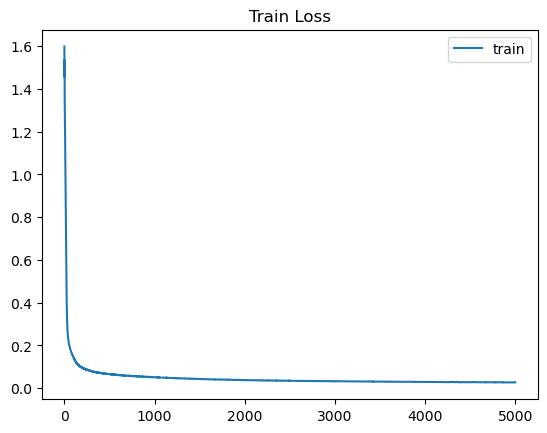

In [23]:
EMBEDDING_SIZE = 100
HIDDEN_SIZE = 256
LR = 1e-3
TIME_STEP = 300
EXPERIMENT_NAME = 'exp1'

tmp_df = train_df.copy() 

X_train = make_sequence(train_df, 'value', time_step=TIME_STEP)

X_train = X_train.float()

autoencoder = Autoencoder(input_size = TIME_STEP, embedding_size = EMBEDDING_SIZE, hidden_size = HIDDEN_SIZE, dropout = 0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
autoencoder, history = tune(autoencoder, X_train, optimizer, criterion, epochs = 5000)

plot(history)

torch.save(autoencoder, f'autoencoder_{TIME_STEP}d.best.v1.torch')


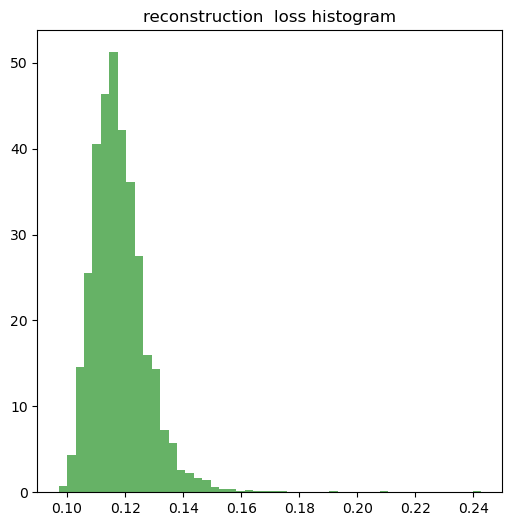

reconstruction threshold =  0.24271453273324967


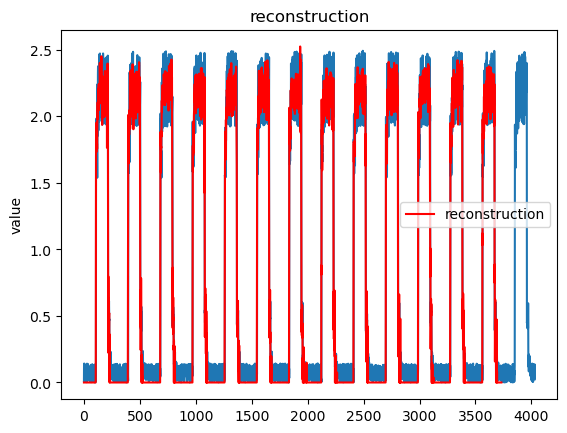

mae loss =  tensor([0.1185, 0.1448, 0.1286,  ..., 0.1244, 0.1193, 0.1402],
       dtype=torch.float64, grad_fn=<MeanBackward1>)


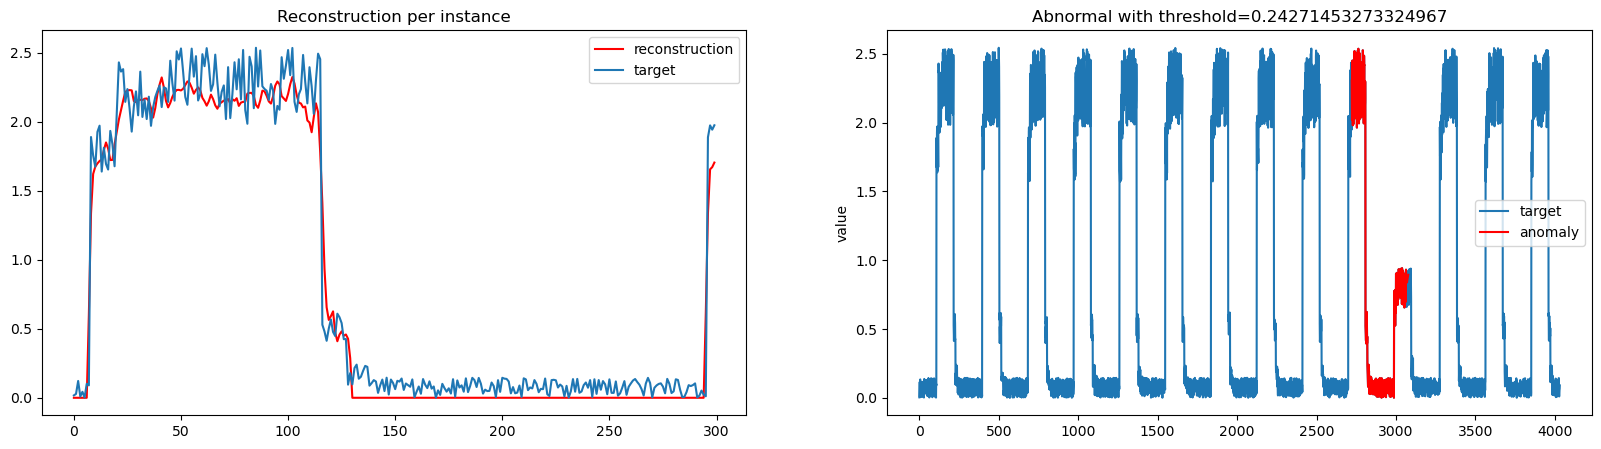

mae loss =  tensor([0.1698, 0.1640, 0.1723,  ..., 0.1440, 0.1880, 0.1510],
       dtype=torch.float64, grad_fn=<MeanBackward1>)


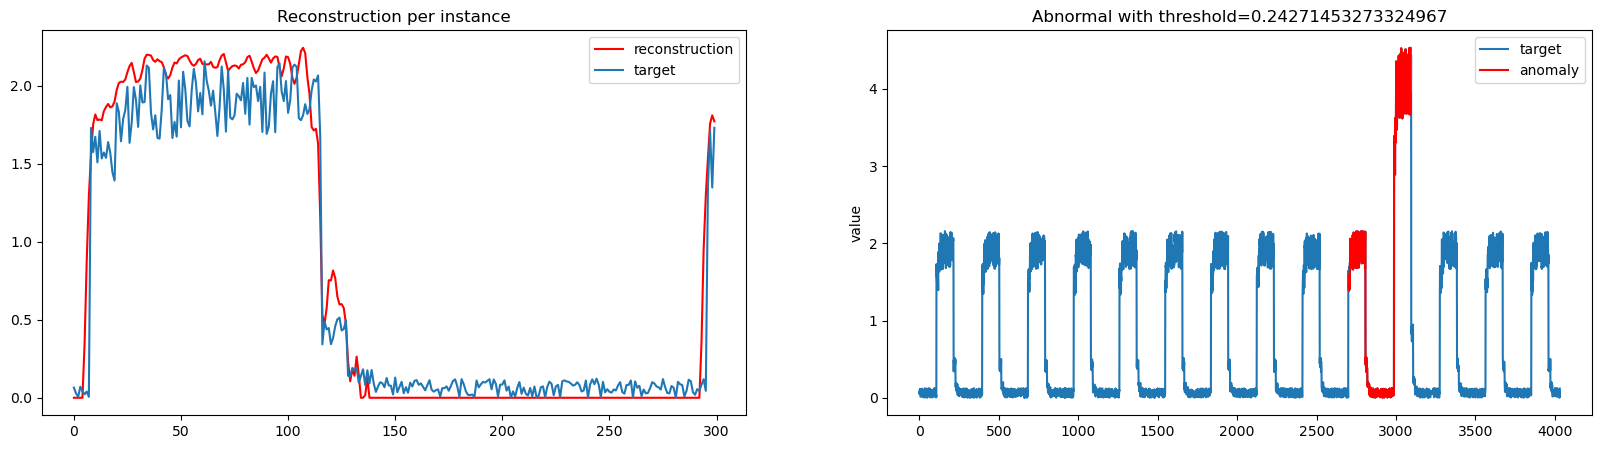

In [25]:
threshold = get_threshold(autoencoder, train_df, timestep = TIME_STEP, plot = True, percentile=100)
print('reconstruction threshold = ', threshold)
plot_reconstruction(autoencoder, train_df, timestep=TIME_STEP)

#evaluate
detect_anomaly(autoencoder, valid_df, timestep = TIME_STEP, threshold=threshold)
detect_anomaly(autoencoder, test_df, timestep = TIME_STEP, threshold = threshold)

# Observation

After many trials, we conclude that linear layer can somewhat resemble the original data, but not very accurate. It can tell the location of anomaly like in previous valid and test plot reconstruction. But it's a little a ahead of the actual anomaly. 